## Stock Price Prdictions and Analysis for Information Technology Companies

I initially chose the LSTM due to the volatile nature of the stock prices. LSTM(Long Short-Term Model) is proven to be good at predicting very volatile things due its mechanism.

In [1]:
#importing all the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas_ta
import tensorflow as tf
import joblib

# Extracting the dataset for Oracle

In [2]:
#importing the dataset for Oracle corporation from 2015 to the end of 2023
ticker = 'ORCL'
oracle_df = yf.download(ticker, start = '2015-01-01', end = '2023-12-31')
oracle_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,45.020000,45.189999,43.970001,44.330002,38.042252,15070200
2015-01-05,44.160000,44.250000,43.580002,43.590000,37.508759,18369400
2015-01-06,44.060001,44.180000,42.990002,43.139999,37.121544,19229500
2015-01-07,43.330002,43.520000,43.009998,43.150002,37.130150,13502200
2015-01-08,43.630001,43.939999,43.380001,43.410000,37.353886,17516900


# Checking the information and shape of the dataframe, and also if there are any null values which we might need to change

In [3]:
print(oracle_df.shape)
print(oracle_df.info()) #to check for all the datatypes of the features

(2264, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2264 non-null   float64
 1   High       2264 non-null   float64
 2   Low        2264 non-null   float64
 3   Close      2264 non-null   float64
 4   Adj Close  2264 non-null   float64
 5   Volume     2264 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB
None


In [4]:
print(oracle_df.duplicated().sum()) #to check for any duplicate rows that might exist

0


In [5]:
print(oracle_df.isnull().sum()) #to check for any null values 

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
print(oracle_df.describe()) #to get the summary statistics

              Open         High          Low        Close    Adj Close  \
count  2264.000000  2264.000000  2264.000000  2264.000000  2264.000000   
mean     60.497981    61.109779    59.959792    60.536025    56.624964   
std      21.557608    21.831025    21.307727    21.577619    22.577046   
min      33.799999    34.230000    33.130001    33.939999    29.655432   
25%      44.220001    44.645001    43.977500    44.317500    39.368245   
50%      52.995001    53.424999    52.430000    52.885000    48.912901   
75%      75.562498    76.577497    74.667503    75.810001    73.057693   
max     127.139999   127.540001   125.150002   126.709999   125.003242   

             Volume  
count  2.264000e+03  
mean   1.284404e+07  
std    7.572352e+06  
min    2.168200e+06  
25%    8.167250e+06  
50%    1.110380e+07  
75%    1.520105e+07  
max    7.913840e+07  


# Exploratory Data Analysis

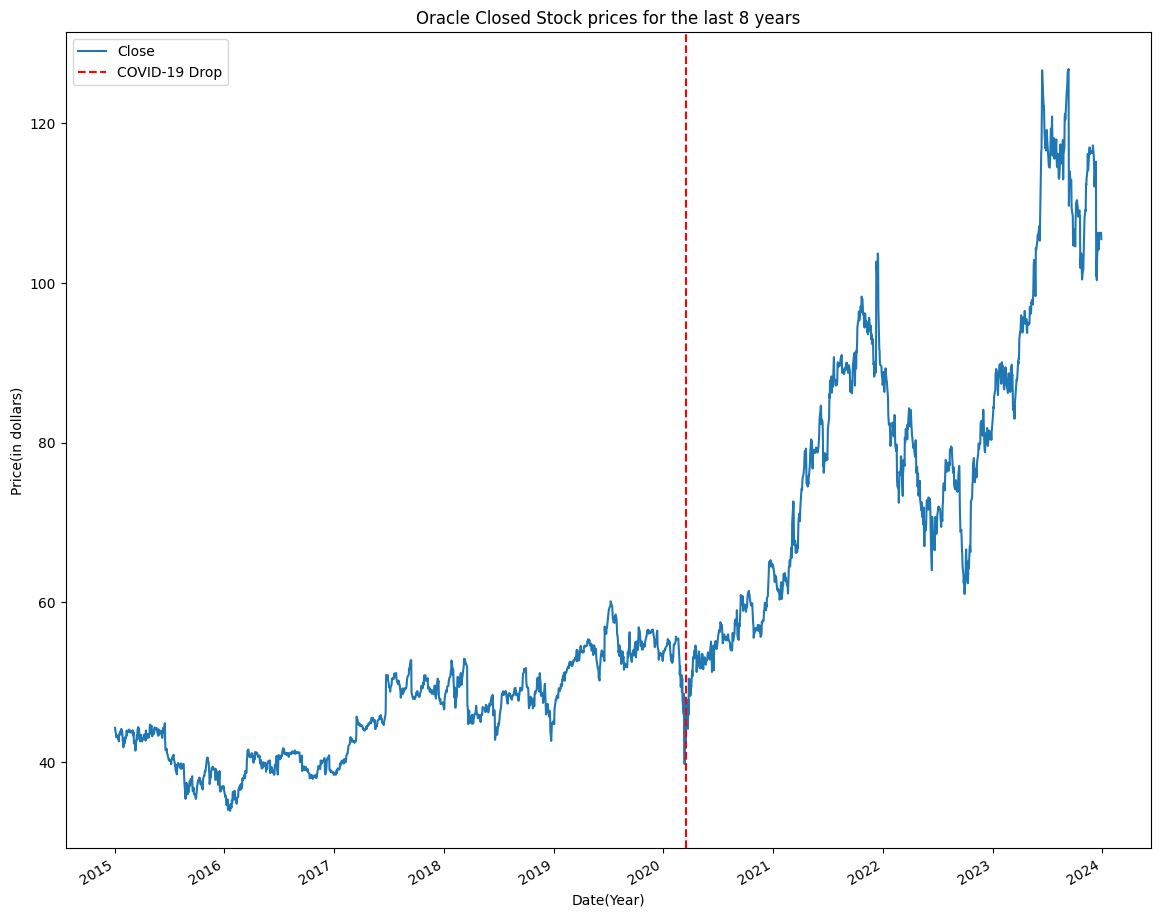

In [7]:
plt.figure(figsize = (14,12))
oracle_df['Close'].plot()
plt.title("Oracle Closed Stock prices for the last 8 years")
plt.ylabel("Price(in dollars)")
plt.xlabel("Date(Year)")
plt.axvline(x=pd.Timestamp('2020-03-15'), color='red', linestyle='--', label='COVID-19 Drop')
plt.legend()
plt.show()

There has been a general increasing trend from 2015 to 2023.
There was a substantial drop in March, 2020 due to the effect of Covid-19. 
Oracle's stock price experienced a significant rise, with a local peak around late 2021 to early 2022. This suggests positive market sentiment and strong company performance during this period.
In the last year (2023), the stock price has been relatively volatile, reflecting broader market uncertainties and potential company-specific factors.

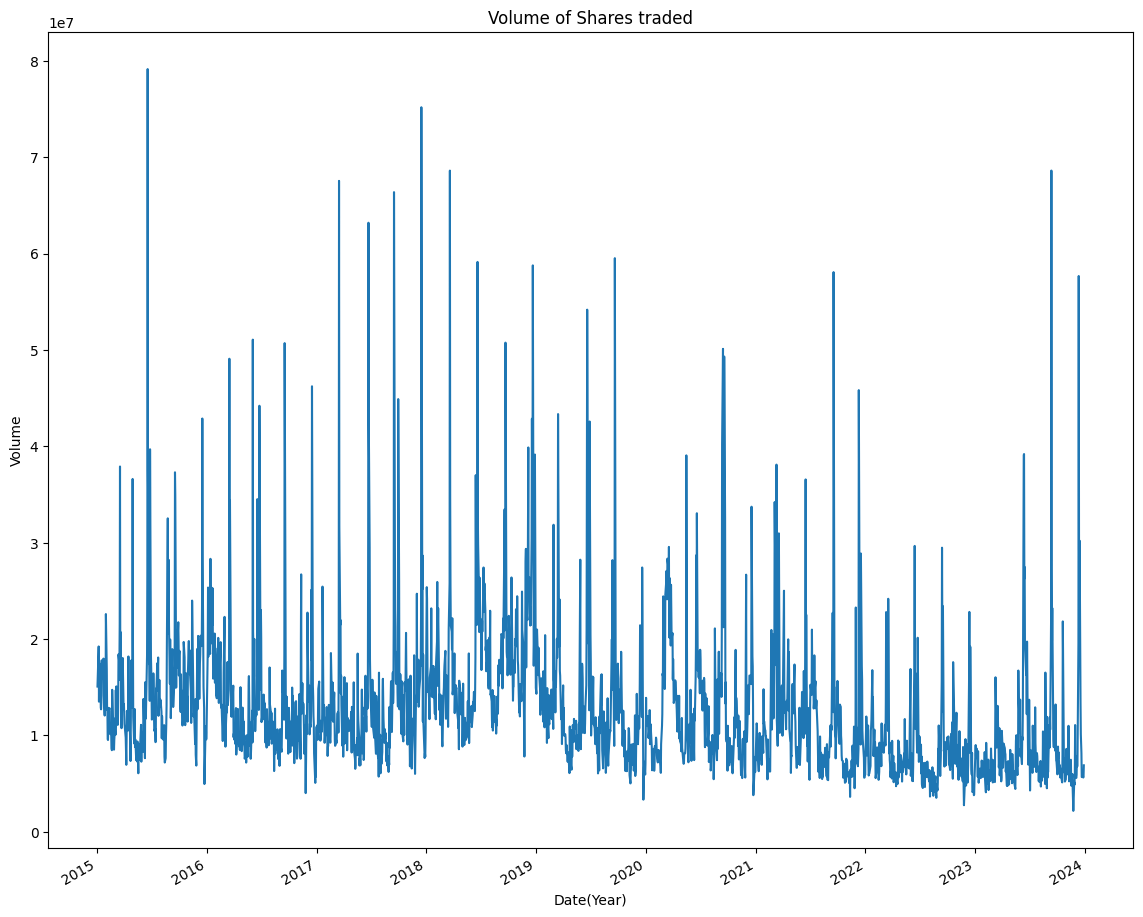

In [8]:
plt.figure(figsize = (14,12))
oracle_df['Volume'].plot()
plt.title("Volume of Shares traded")
plt.xlabel("Date(Year)")
plt.ylabel("Volume")
plt.show()

The regular peaks and troughs in the trading volume shows frequent trading by investors. 
Slightly broad peak during March 2020 approximately, shows the investors reaction to the decrease in the price of the shares due to Covid-19. This reflects heightened market activity and investor reaction to the market turmoil.

In [9]:
df = oracle_df.copy()

# Feature Engineering

# Technical Indicators
1. Daily return -
Daily return on a stock is used to measure the day to day performance of stocks, it is the percentage change in the closed price of stock that day compared to the preceding day. A positive Daily Return means that the stock price has appreciated from the previous day.

2. RSI(Relative Strength Index) - 
The relative strength index (RSI) is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security. An asset is usually considered overbought when the RSI is above 70 and oversold when it is below 30. It is used to predict the behaviour of a security.

3. SMA (Simple Moving Averages) - 
A simple moving average calculates the average price during a specified period of time. It is a technical indicator that can aid in determining if an asset price will continue or if it will reverse a bull or bear trend.

4. MACD(Moving Average Convergence Divergence) - The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price, typically the 12-day and 26-day EMAs. It is used to identify potential buy and sell signals by looking for crossovers, divergences, and overbought/oversold conditions.

5. EMA(Exponential Moving Average) - The EMA is a type of moving average that gives more weight to the most recent prices, making it more responsive to new information compared to the simple moving average. It is used to smooth out price data to identify the direction of the trend over a specified period, typically to filter out short-term fluctuations.

I used these specific indicators since they seemed to be the most effective in accurately predicting the next day's stock price for Oracle.
I tried other indicators but did not achieve the same level of success.

In [10]:
df['rsi'] = pandas_ta.rsi(oracle_df['Adj Close'], length=20) #adding a feature, Relative Strength Index
df['SMA_20'] = pandas_ta.sma(oracle_df['Adj Close'], length=20)  # 20-day Simple Moving Average
df['Daily Return'] = df['Adj Close'].pct_change() # calculating the daily return on the stock
df['EMA_20'] = pandas_ta.ema(oracle_df['Adj Close'], length=20)  # calculating the Exponential Moving Average over 20 day period
macd = pandas_ta.macd(oracle_df['Adj Close'])  # MACD calculation
df['MACD'] = macd['MACD_12_26_9'] #Using the most common (12/26) MACD

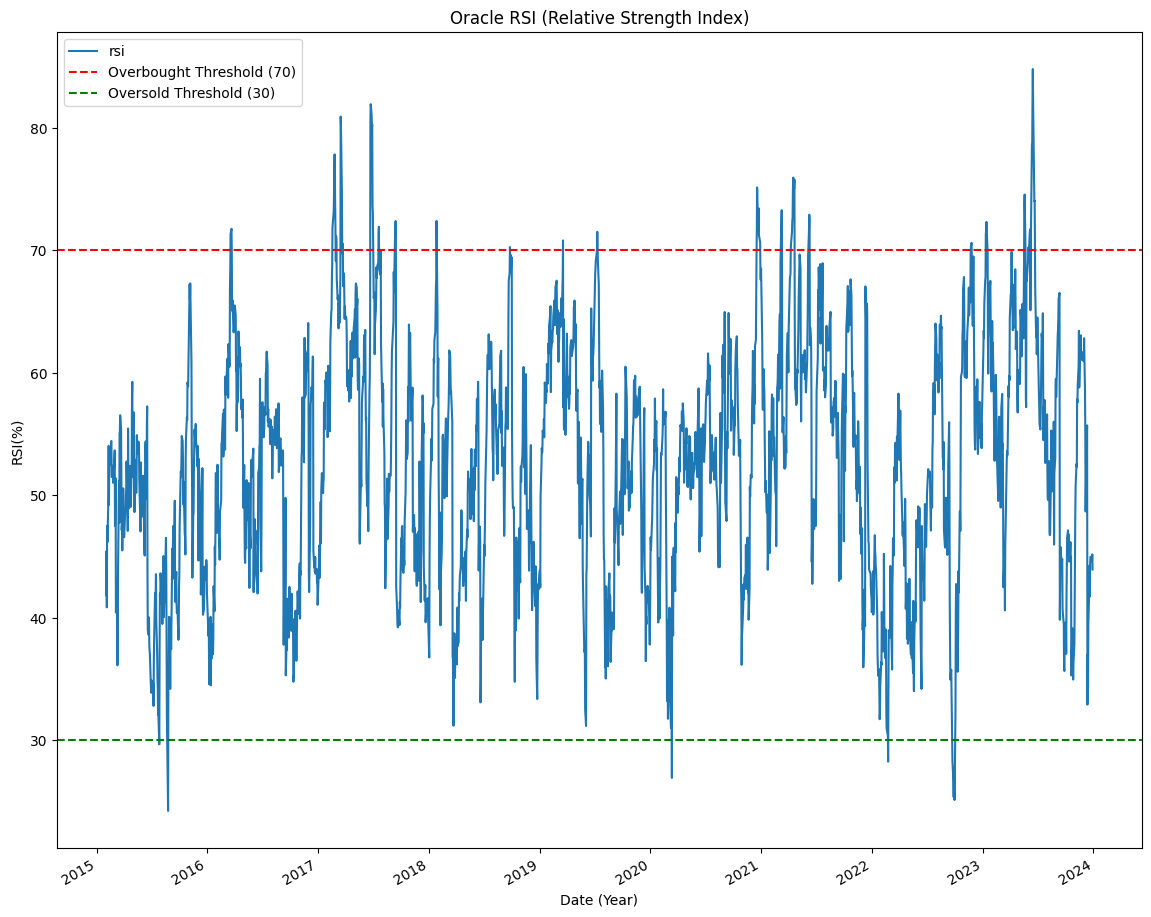

In [11]:
plt.figure(figsize = (14,12))
df['rsi'].plot()
plt.title("Oracle RSI (Relative Strength Index)")
plt.ylabel("RSI(%)")
plt.xlabel("Date (Year)")
plt.axhline(y=70, color='red', linestyle='--', label='Overbought Threshold (70)')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold Threshold (30)')
plt.legend()
plt.show()

The RSI fluctuates significantly, often reaching overbought levels (above 70) and oversold levels (below 30).
Frequent crossings of the overbought threshold suggest the stock often enters a state where it might be due for a price correction.
Frequent crossings of the oversold threshold indicate multiple potential buying opportunities where the stock price might rebound.

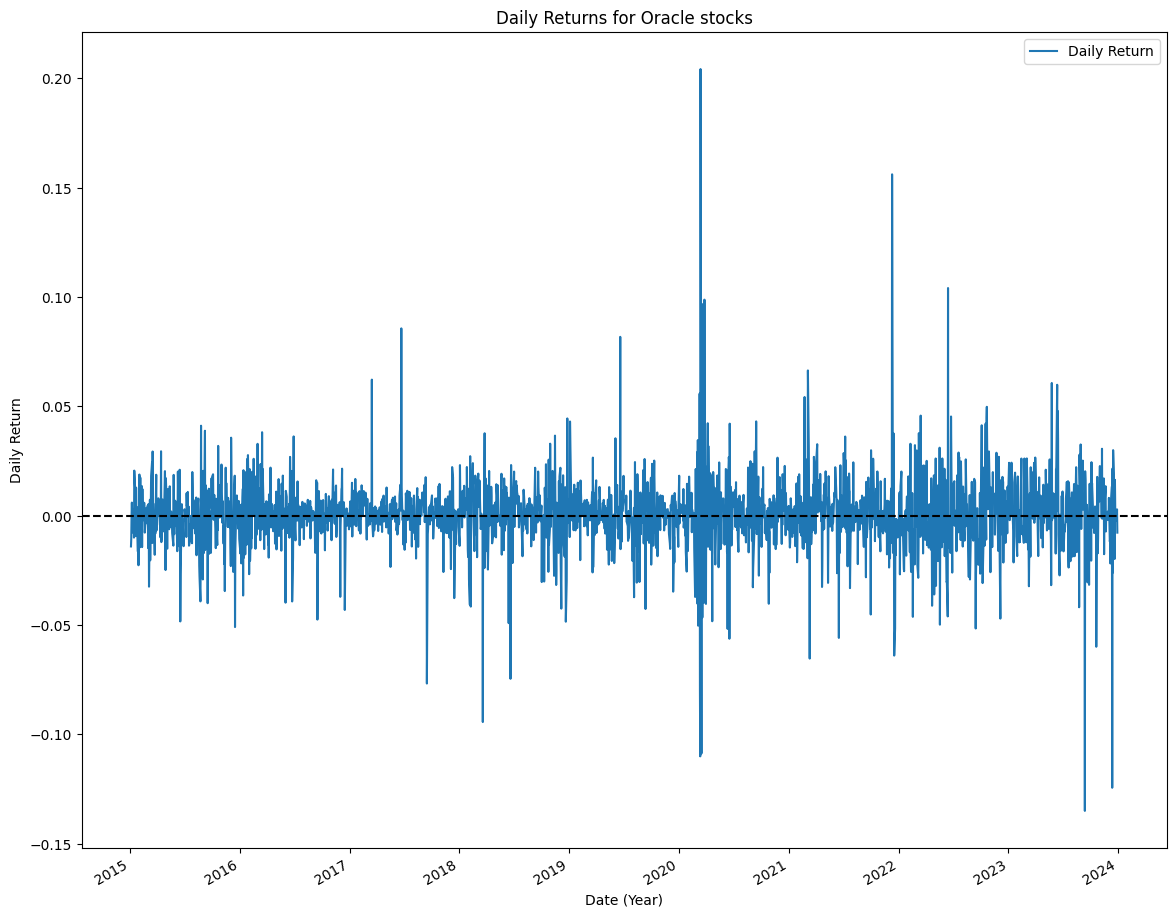

In [12]:
plt.figure(figsize=(14, 12))
df['Daily Return'].plot(label='Daily Return')
plt.title('Daily Returns for Oracle stocks')
plt.xlabel('Date (Year)')
plt.ylabel('Daily Return')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

The daily returns exhibit considerable volatility, with numerous spikes both positive and negative.
Despite the upward trend in the stock price, the daily returns show that the stock experiences substantial daily fluctuations.
The overall distribution of returns is centered around zero, indicating that on many days, the stock experiences minimal change, but there are occasional days with significant price movements.

In [13]:
np.mean(df['Daily Return'])

0.0005894731126658067

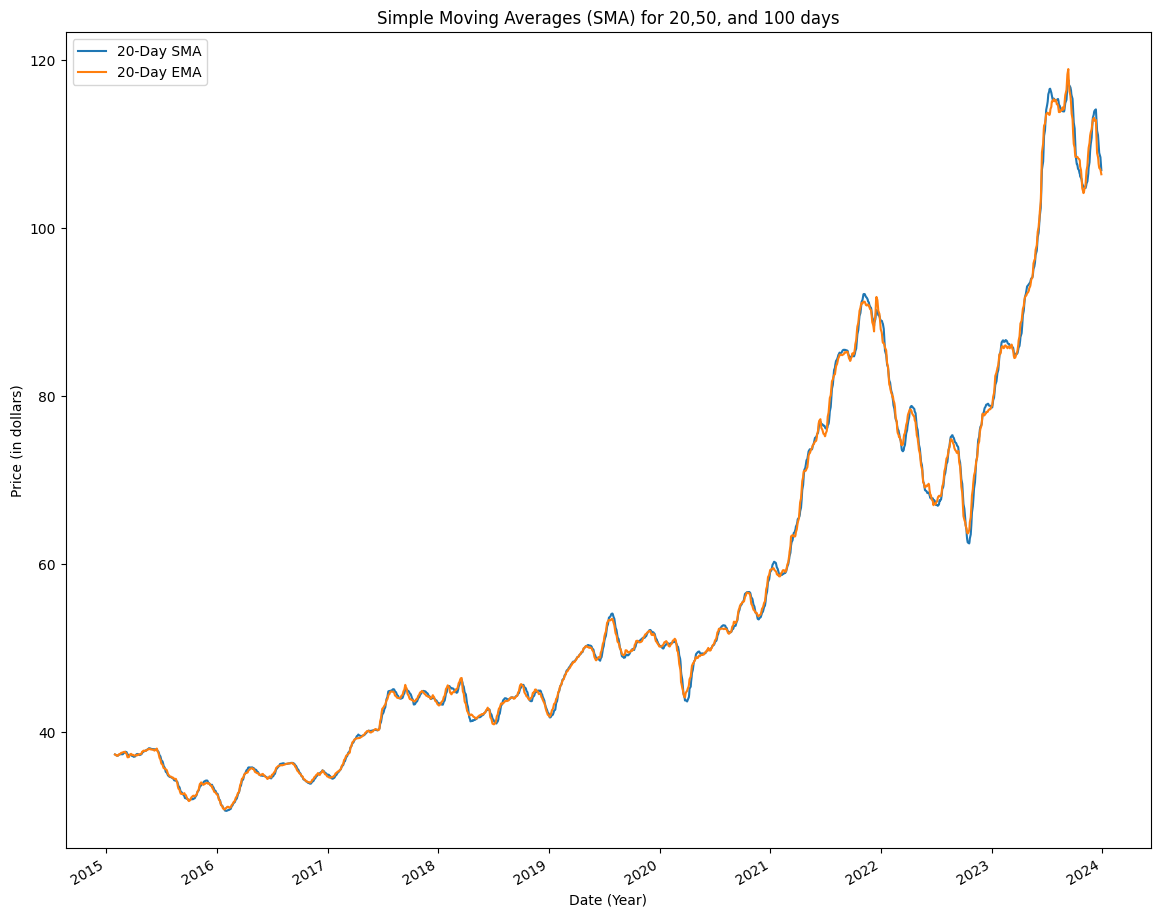

In [14]:
plt.figure(figsize=(14, 12))
df['SMA_20'].plot(label='20-Day SMA')
df['EMA_20'].plot(label='20-Day EMA')
#df['SMA_50'].plot(label='50-Day SMA')
#df['SMA_100'].plot(label='100-Day SMA')
plt.title('Simple Moving Averages (SMA) and Estimated Moving Avergaes(EMA) for 20 days')
plt.xlabel('Date (Year)')
plt.ylabel('Price (in dollars)')
plt.legend()
plt.show()

The stock price has shown a consistent upward trend from 2015 to 2023, as indicated by both the 20-day SMA and EMA.
The EMA, which reacts more quickly to price changes, confirms the overall trend direction and provides early signals of potential price reversals or accelerations.
The close alignment of the SMA and EMA suggests a stable and sustained trend without significant long-term divergence.

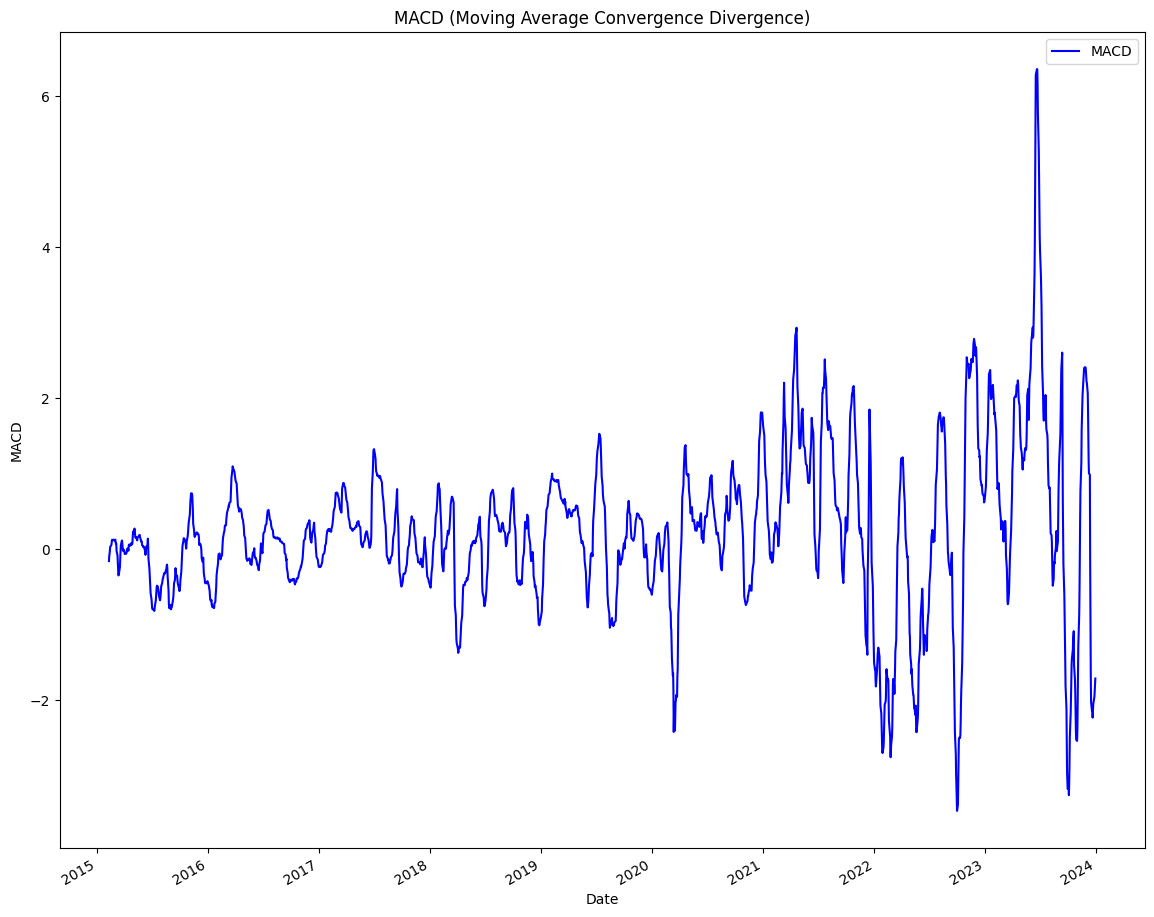

In [16]:
plt.figure(figsize=(14, 12))
df['MACD'].plot(label='MACD', color='blue')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.show()


# APPROACH 1 - Using Technical Indicators

The target column is the price of the stock for the next day

In [17]:
df['target'] = df['Adj Close'].shift(-1)

I dropped these columns since I aimed at only including the technical indicators to accurately predict the stock prices.

In [18]:
df = df.drop(columns=['Open', 'High', 'Low', 'Close','Volume','Daily Return'])

In [19]:
df.head(29)
df.tail(40)

,Adj Close,rsi,SMA_20,EMA_20,MACD,target
Date,,,,,,
2023-11-02,105.816284,48.558571,104.921535,104.388694,-1.683846,106.984650
2023-11-03,106.984650,50.699553,104.846825,104.635928,-1.278709,108.034195
2023-11-06,108.034195,52.566301,104.806834,104.959573,-0.862997,107.915375
2023-11-07,107.915375,52.330171,104.790992,105.241078,-0.536941,111.222458
2023-11-08,111.222458,57.874190,104.924166,105.810733,-0.011551,111.073936
2023-11-09,111.073936,57.557739,105.076153,106.311990,0.388362,111.955147
2023-11-10,111.955147,58.959269,105.314777,106.849434,0.767555,113.024506
2023-11-13,113.024506,60.620369,105.584095,107.437536,1.141201,114.955269
2023-11-14,114.955269,63.433235,105.933614,108.153510,1.574960,112.935394


In [20]:
df = df.dropna(axis = 0) #dropping the last row since it had a NaN value
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2238 entries, 2015-02-09 to 2023-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2238 non-null   float64
 1   rsi        2238 non-null   float64
 2   SMA_20     2238 non-null   float64
 3   EMA_20     2238 non-null   float64
 4   MACD       2238 non-null   float64
 5   target     2238 non-null   float64
dtypes: float64(6)
memory usage: 122.4 KB


<Axes: >

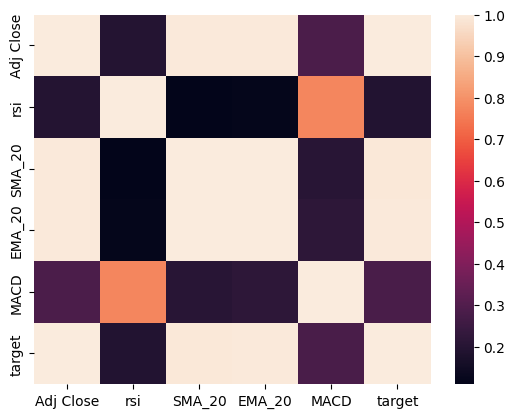

In [21]:
sns.heatmap(df.corr())

Thus, from the heatmap above, we can see that SMA AND EMA have the highest correlation to target.

In [22]:
# scaling the values for the model to be more accurate 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [23]:
training_data_len = int(np.ceil(len(df) * .7)) # setting the train-test ratio to be 70-30

In [24]:
# Preparing the df for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Features for the past 'time_step' days
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Predicting the price
    return np.array(dataX), np.array(dataY)


In [25]:
time_step = 10  # Number of past days to consider
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
X_train, X_test = X[0:training_data_len], X[training_data_len:len(X)]
y_train, y_test = y[0:training_data_len], y[training_data_len:len(y)]

I read up on numerous articles that proves that LSTM was the most accurate predictor for stock prices due to their highly volatile nature. This motivated me to try out a combination of LSTM and Dense layers. 
I tried several different combinations of nodes and neurons to avoid overfitting on the data and minimize both training and validation loss

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Building the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5


C:\Users\anshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1567/1567 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 9.7307e-04 - val_loss: 0.0062
Epoch 2/5
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.0624e-04 - val_loss: 4.4981e-04
Epoch 3/5
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3384e-04 - val_loss: 0.0017
Epoch 4/5
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.5540e-05 - val_loss: 9.5533e-05
Epoch 5/5
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.5383e-05 - val_loss: 6.6370e-04


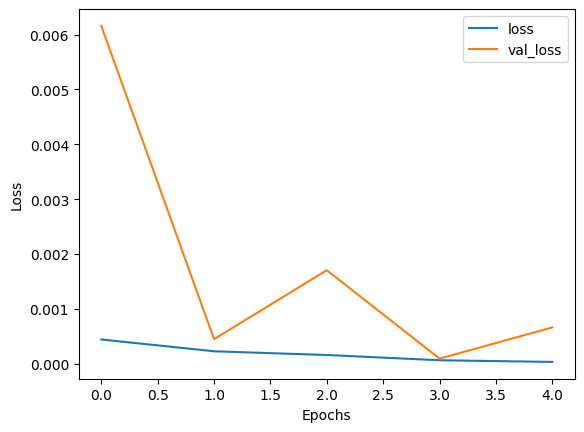

In [27]:
# To get the graph for validation vs training loss
losses=pd.DataFrame(model.history.history)
losses.plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

I tried using all OHLC as well as technical indicators for the model, however they overfit the data and did not get as much success

In [28]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X.shape[2] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X.shape[2] - 1))), axis=1))[:, 0]
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2] - 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2] - 1))), axis=1))[:, 0]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


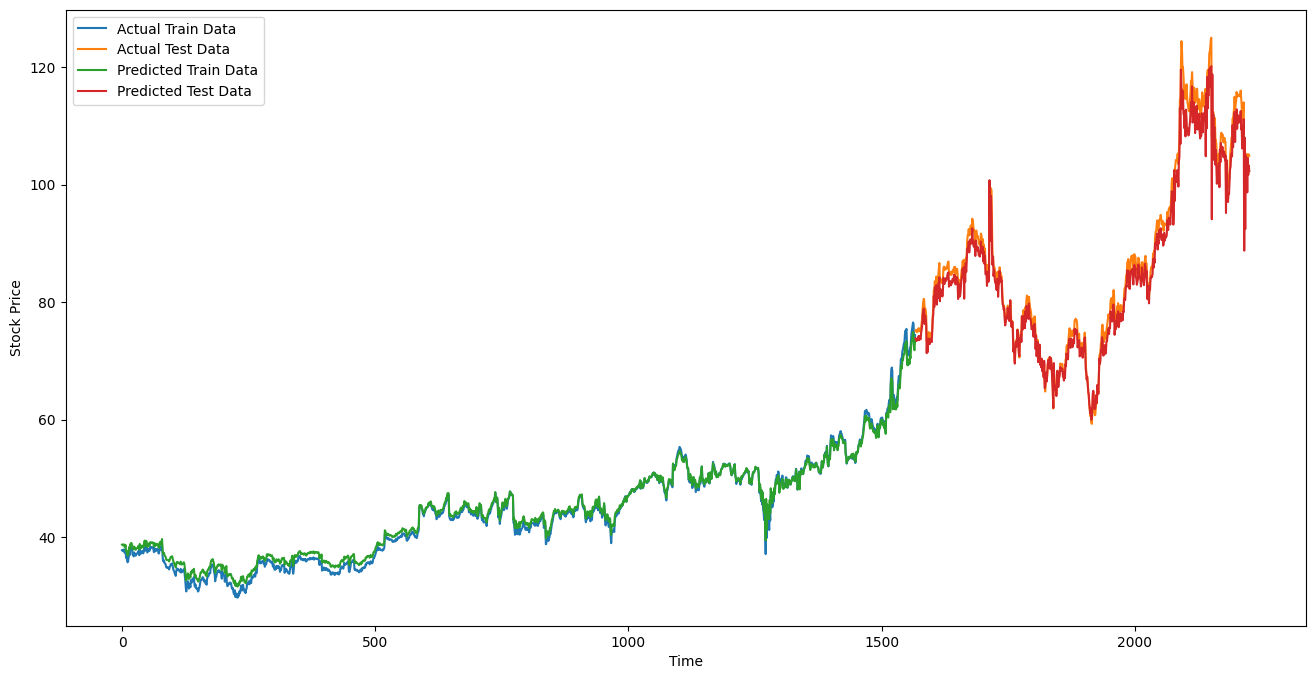

In [29]:
# Plotting the results
plt.figure(figsize=(16, 8))
plt.plot(y_train_inv, label='Actual Train Data')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, label='Actual Test Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predicted Test Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [30]:
# To get the rmse and mae for model accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
train_mae = mean_absolute_error(y_train_inv, train_predict)
test_mae = mean_absolute_error(y_test_inv, test_predict)

In [31]:
# Printing the rmse and mae
print(f'Mean Absolute Error (MAE) - Original: {test_mae}')
print(f'Root Mean Squared Error (RMSE) - Original: {test_rmse}')

Mean Absolute Error (MAE) - Original: 1.9356297403934708
Root Mean Squared Error (RMSE) - Original: 2.456389463552186


# Saving the model and scaler for future use

In [32]:
model.save('tech_indicators_model.h5')

In [33]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']